In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

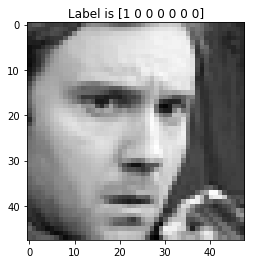

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import csv



def show_sample(data, label):
    # Make those columns into a array of 8-bits pixels
    # The pixel intensity values are integers from 0 to 255
    pixels = np.array(data, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    n = int(np.sqrt(len(pixels)))
    assert n**2 == len(pixels)
    pixels = pixels.reshape(n, n)

    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    
    
def one_hot(x, size):
    list = [0] * size
    list[x] = 1
    return list



class DataSet(object):
        
    def __init__(self, fileName):
        self._fileName = fileName
        self._train = dict()
        self._validate = dict()
        self._test = dict()
        
        
    def create_sets(self, ds = None, oneHot = True):
        self._train['labels'] = np.array([ r['emotion'] for r in ds 
                    if r['usage'] == 'Training' ])
        self._train['images'] = np.array([ r['pixels'] for r in ds 
                    if r['usage'] == 'Training' ])
        
        self._validate['labels'] = np.array([ r['emotion'] for r in ds 
                    if r['usage'] == 'PublicTest' ])
        self._validate['images'] = np.array([ r['pixels'] for r in ds 
                    if r['usage'] == 'PublicTest' ])
        
        self._test['labels'] = np.array([ r['emotion'] for r in ds 
                    if r['usage'] == 'PrivateTest' ])
        self._test['images'] = np.array([ r['pixels'] for r in ds 
                    if r['usage'] == 'PrivateTest' ])
    
        if oneHot:
            maxVal = max(
                    max(self._train['labels']),
                    max(self._validate['labels']),
                    max(self._test['labels'])
            )
            self._train['labels'] = np.array(
                    [one_hot(x, maxVal + 1) for x in self._train['labels']])
            self._validate['labels'] = np.array(
                    [one_hot(x, maxVal + 1) for x in self._validate['labels']])
            self._test['labels'] = np.array(
                    [one_hot(x, maxVal + 1) for x in self._test['labels']])
        
        
    def read_data(self):
        csvFile = open(self._fileName, 'rt')
        picReader = csv.reader(csvFile, delimiter=',')

        line = 0
        dataset = []
        for row in picReader:
            line += 1
            
            # skip the header
            if line == 1:
                # print(row)
                continue
            
            d = dict()
            d['emotion'] = np.array(int(row[0]))
            d['pixels'] = np.array([int(x) for x in row[1].split()])
            d['usage'] = np.array(row[2])
            
            dataset.append(d)
            
        csvFile.close()   
        self.create_sets(dataset)
        

    @property
    def dataset(self):
        return self._dataset
    
    
    @property
    def train(self):
        return self._train
    
    
    @property
    def validate(self):
        return self._validate
    
    
    @property
    def test(self):
        return self._test



class Batch(object):
        
    def __init__(self, num_samples, batch_size, shuffle = True):
        self._num_samples = num_samples
        self._start = 0
        self._perm = None
        self._shuffle = shuffle
        self._batch_size = batch_size
        
    
    def next_batch(self, samples, labels):
        assert len(samples) == self._num_samples
        assert len(labels) == self._num_samples
                  
        if self._start == 0:
            self._perm = np.arange(self._num_samples)
            if self._shuffle:
                np.random.shuffle(self._perm)
                
        window = None
                
        # check where there are sufficient samples here
        if self._start + self._batch_size > self._num_samples:
            rest_num_samples = self._num_samples - self._start
            window = self._perm[self._start:self._num_samples]
            
            # prepare to wrap around
            if self._shuffle:
                np.random.shuffle(self._perm)
                
            # add the remaining of the batch
            self._start = 0
            remaining = self._batch_size - rest_num_samples
            window = np.concatenate((
                    window, 
                    self._perm[self._start:remaining]), 
                axis=0)
    
            self._start += remaining
        else:
            # there is no danger of wrapping around
            nextpos = self._start + self._batch_size
            window = self._perm[self._start:nextpos]
            
            self._start = nextpos
        
        return samples[window], labels[window]
    


ds = DataSet('fer2013/fer2013.csv')
ds.read_data()

show_sample(ds.train['images'][0], ds.train['labels'][0])



# Simple ICML2013 learning with a two layer fully-connected network

In [26]:
x = tf.placeholder(tf.float32, shape=[None, 2304])
y_ = tf.placeholder(tf.float32, shape=[None, 7])

W = tf.Variable(tf.zeros([2304, 7]))
b = tf.Variable(tf.zeros([7]))

y = tf.matmul(x, W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y))

#train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy)

init_global = tf.global_variables_initializer()

In [27]:
with tf.Session() as sess:
    # initialize variables
    sess.run(init_global)
    
    b = Batch(len(ds.train['images']), 100)
    
    for _ in range(10000):
        batch_samples, batch_labels = b.next_batch(ds.train['images'], ds.train['labels'])
        sess.run(train_step, feed_dict={x: batch_samples, y_: batch_labels})
        if _ % 1000 == 0:
            correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print('train acc.: %g' % accuracy.eval(feed_dict={x: ds.train['images'], y_: ds.train['labels']}))
    

    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('test acc.: %g' %accuracy.eval(feed_dict={x: ds.validate['images'], y_: ds.validate['labels']}))


train acc.: 0.25128
train acc.: 0.275419
train acc.: 0.296562
train acc.: 0.315058
train acc.: 0.266815
train acc.: 0.267616
train acc.: 0.177958
train acc.: 0.264168
train acc.: 0.295865
train acc.: 0.281723
test acc.: 0.218445


# Multilayer Convolutional Network for ICML2013

In [24]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# stride of one
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    #return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

# max pooling over 2x2 blocks
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# if code is run multiple times in the same session, 
# one would like to remove previous graph structure;
# otherwise all history is preserved
tf.reset_default_graph()

# placeholders
with tf.name_scope("input"):
    x = tf.placeholder(tf.float32, [None, 2304])
    
with tf.name_scope("desired"):
    y_ = tf.placeholder(tf.float32, [None, 7])

# the input x has to be reshaped to a 4d tensor, with second and third dimensions
# corresponding to image width and height, and the last - number of output channels
with tf.name_scope("reshape"):
    x_image = tf.reshape(x, [-1, 48, 48, 1])

# convolve the image, add the bias, apply ReLU and max pool
# size is reduced from 48x48 to 24x24
with tf.name_scope("conv1"):
    # receptive map is 5x5
    # there are 32 feature maps
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    
with tf.name_scope("pool1"):
    h_pool1 = max_pool_2x2(h_conv1)

with tf.name_scope("conv2"):
    # second convolutional layer; there are 64 feature maps
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    # size is reduced from 24x24 to 12x12
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

with tf.name_scope("pool2"):
    h_pool2 = max_pool_2x2(h_conv2)

with tf.name_scope("fc1"):
    # fully conected layer with 1024 neurons
    W_fc1 = weight_variable([12 * 12 * 64, 1024])
    #W_fc1 = weight_variable([4 * 4 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 12*12*64])
    #h_pool2_flat = tf.reshape(h_pool2, [-1, 4*4*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

with tf.name_scope("dropout"):
    # dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

with tf.name_scope("fc2"):
    # output layer
    W_fc2 = weight_variable([1024, 7])
    b_fc2 = bias_variable([7])

with tf.name_scope("output"):
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [25]:
with tf.name_scope("cost"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

with tf.name_scope("optimizer"):
    train_step = tf.train.AdamOptimizer(1e-5).minimize(cross_entropy)
    
with tf.name_scope("prediction"):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # add accuracy to summary
    tf.summary.scalar("accuracy", accuracy)

# prepare summary variable(s) to be shown in TensorBoard
summary = tf.summary.merge_all()
    
# prepare TensorBoard graph
# graph_location = tempfile.mkdtemp()
graph_location = './icml_graph/'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

init_global = tf.global_variables_initializer()

with tf.Session() as sess:
    #with tf.device('/cpu:0'):
    sess.run(init_global)
    
    b = Batch(len(ds.train['images']), 50)
    for i in range(20000):
        batch_samples, batch_labels = b.next_batch(ds.train['images'], ds.train['labels'])
        
        if i % 100 == 0:
            #train_accuracy = accuracy.eval(feed_dict={
            #    x: batch[0], y_: batch[1], keep_prob: 1.0})
            
            # update the summary
            #run_summary = sess.run(summary, feed_dict={
            #    x: batch[0], y_: batch[1], keep_prob: 1.0})
            
            run_summary, train_accuracy = sess.run([summary, accuracy], feed_dict={
                x: batch_samples, y_: batch_labels, keep_prob: 1.0})
            train_writer.add_summary(run_summary, i)
            
            print('step %d, training accuracy %g' % (i, train_accuracy))
            
        sess.run(train_step, feed_dict={
                x: batch_samples, y_: batch_labels, keep_prob: 1.0})
        #train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
        
        
        
    print('test accuracy %g' % accuracy.eval(feed_dict={
                x: ds.validate['images'], y_: ds.validate['labels'], keep_prob: 1.0}))


Saving graph to: ./icml_graph/
step 0, training accuracy 0.1
step 100, training accuracy 0.16
step 200, training accuracy 0.24
step 300, training accuracy 0.26
step 400, training accuracy 0.22
step 500, training accuracy 0.24
step 600, training accuracy 0.22
step 700, training accuracy 0.24
step 800, training accuracy 0.18
step 900, training accuracy 0.24
step 1000, training accuracy 0.18
step 1100, training accuracy 0.22
step 1200, training accuracy 0.18
step 1300, training accuracy 0.3
step 1400, training accuracy 0.18
step 1500, training accuracy 0.16
step 1600, training accuracy 0.3
step 1700, training accuracy 0.24
step 1800, training accuracy 0.34
step 1900, training accuracy 0.36
step 2000, training accuracy 0.34
step 2100, training accuracy 0.24
step 2200, training accuracy 0.34
step 2300, training accuracy 0.26
step 2400, training accuracy 0.32
step 2500, training accuracy 0.26
step 2600, training accuracy 0.28
step 2700, training accuracy 0.24
step 2800, training accuracy 0.3